In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
import time
import os
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import glob
from PIL import Image
import pickle
import shutil
import matplotlib.pyplot as plt


dtype = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available()==False:
  dtype=torch.FloatTensor
print(device,dtype)

cuda <class 'torch.cuda.FloatTensor'>


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/gan colourization/dataset/colour_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/gan colourization/dataset/train')

In [ ]:
#!pip install fastai --upgrade

     |████████████████████████████████| 194kB 27.7MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
#from fastai.data.external import untar_data, URLs
#coco_path = untar_data(URLs.COCO_SAMPLE)
#coco_path = str(coco_path) + "/train_sample"
#use_colab = True

In [ ]:
'''
path = coco_path
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))
'''

8000 2000


In [ ]:
class set_config:

  def __init__(self):
    self.cuda=torch.cuda.is_available()
    self.weight_decay=0 
    self.lr=0.00009 
    self.test_img = None
    self.batch_size = 8 
    self.mode='train'
    self.resume= False
    self.path='/content/drive/MyDrive/gan colourization'
    self.lambd =100
    self.epoch_ul = 60
    self.gpath= self.path+ 'weights/'
    self.dpath = self.path+'weights/'
    self.loss_path = '/content/drive/MyDrive/gan colourization/loss_history'
    self.save_test = True

cfg=set_config() 

In [ ]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    
    self.c1 = nn.Sequential(nn.Conv2d(  1, 64,1, bias=False  ) , nn.LeakyReLU(0.2))
    self.c2 = nn.Sequential(nn.Conv2d( 64, 64,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(64 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c3 = nn.Sequential(nn.Conv2d( 64,128,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(128 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c4 = nn.Sequential(nn.Conv2d(128,256,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(256 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c5 = nn.Sequential(nn.Conv2d(256,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512 , momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c6 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c7 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512 , momentum = 0.5), nn.LeakyReLU(0.2))
    self.c8 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512 , momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.dconv7 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1, bias=False)
    self.bn_relu7 = nn.Sequential(nn.BatchNorm2d(1024 , momentum = 0.5) , nn.ReLU(inplace = True ))
    self.dconv6 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False)
    self.bn_relu6 = nn.Sequential(nn.BatchNorm2d(1024 , momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv5 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False)
    self.bn_relu5 = nn.Sequential(nn.BatchNorm2d(1024 , momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv4 = nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1, bias=False)
    self.bn_relu4 = nn.Sequential(nn.BatchNorm2d(512, momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv3 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1, bias=False)
    self.bn_relu3 = nn.Sequential(nn.BatchNorm2d(256, momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv2 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1, bias=False)
    self.bn_relu2 = nn.Sequential(nn.BatchNorm2d(128, momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.dconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)
    self.bn_relu1 = nn.Sequential(nn.BatchNorm2d(128, momentum = 0.5 ) , nn.ReLU(inplace = True ))
    self.final = nn.Conv2d(128 , 2 , 1 , bias = False )
    self.Tanh = nn.Tanh()

  def forward(self , x):
    out = x
    out = self.c1(out)
    p1 = out
    out = self.c2(out)
    p2 = out
    out = self.c3(out)
    p3 = out
    out = self.c4(out)
    p4 = out
    out = self.c5(out)
    p5 = out
    out = self.c6(out)
    p6 = out
    out = self.c7(out)
    p7 = out
    out = self.c8(out)
    out = self.dconv7(out)
    out = torch.cat((out , p7) , 1 )
    out = self.bn_relu7(out)
    
    out = self.dconv6(out)
    out = torch.cat((out , p6) , 1 )
    out = self.bn_relu6(out)
    
    out = self.dconv5(out)
    out = torch.cat((out , p5) , 1 )
    out = self.bn_relu5(out)
    
    out = self.dconv4(out)
    out = torch.cat((out , p4) , 1 )
    out = self.bn_relu4(out)
    
    out = self.dconv3(out)
    out = torch.cat((out , p3) , 1 )
    out = self.bn_relu3(out)
    
    out = self.dconv2(out)
    out = torch.cat((out , p2) , 1 )
    out = self.bn_relu2(out)
    
    out = self.dconv1(out)
    out = torch.cat((out , p1) , 1 )
    out = self.bn_relu1(out)
    
    out = self.final(out)
    out = self.Tanh(out)
    return out

  def initialize_weights(self):

      for name,module in self.named_modules():
        if isinstance(module,nn.Conv2d) or isinstance(module,nn.ConvTranspose2d):
          nn.init.xavier_uniform_(module.weight.data)
          if module.bias is not None:
            module.bias.data.zero_()


  
    




In [ ]:
class Discriminator(nn.Module):

  def __init__(self , mode = 'train'):
    
    super().__init__()
    self.mode = mode
    self.c1 = nn.Sequential(nn.Conv2d(  3 , 64,1, bias=False  ) , nn.LeakyReLU(0.2))
    self.c2 = nn.Sequential(nn.Conv2d( 64, 64,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(64 ,  momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c3 = nn.Sequential(nn.Conv2d( 64,128,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(128 ,  momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c4 = nn.Sequential(nn.Conv2d(128,256,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(256 , momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c5 = nn.Sequential(nn.Conv2d(256,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512, momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c6 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512, momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c7 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512, momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.c8 = nn.Sequential(nn.Conv2d(512,512,4,padding = 1 , stride = 2, bias=False  ) , nn.BatchNorm2d(512, momentum = 0.5 ), nn.LeakyReLU(0.2))
    self.flat=nn.Flatten()
    self.fc1=nn.Linear(2048,100)
    self.relu9=nn.LeakyReLU(0.2)
    self.fc2=nn.Linear(100,1)

  def forward(self , x ):
    out = x
    out = self.c1(out)
    out = self.c2(out)
    out = self.c3(out)
    out = self.c4(out)
    out = self.c5(out)
    out = self.c6(out)
    out = self.c7(out)
    out = self.c8(out)
    out = self.flat(out)
    out = self.fc1(out)
    out = self.relu9(out)
    out = self.fc2(out)
    out = torch.sigmoid(out)
    return out

  def initialize_weights(self):

      for name,module in self.named_modules():
        if isinstance(module,nn.Conv2d) or isinstance(module,nn.ConvTranspose2d):
          nn.init.xavier_uniform_(module.weight.data)
          if module.bias is not None:
            module.bias.data.zero_()
        if isinstance(module,nn.Linear):
          nn.init.xavier_uniform_(module.weight.data)




In [ ]:
class Places365_loader(data.Dataset):
  def __init__(self , mode = 'train' , path = '/content/drive/MyDrive/gan colourization' ):
    self.mode = mode
    if(mode == 'train'):
      path = '/content/drive/MyDrive/gan colourization/dataset/train/' 
      self.image_path = glob.glob(path+'train/*.*')
    elif mode == 'test':
      self.test_path = path 

  def __getitem__(self , index ):
    if self.mode == 'test':
      image = cv2.imread(self.test_path)
      image = cv2.resize(image , (256,256))
    else:
      image = cv2.imread(self.image_path[index])  
    numpy_lab_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    numpy_lab_image = cv2.cvtColor(numpy_lab_image , cv2.COLOR_RGB2LAB)
    numpy_lab_image= numpy_lab_image.astype(np.float64)
    numpy_lab_image /= 255
    numpy_lab_image=torch.from_numpy(numpy_lab_image.transpose(2,0,1)  )
    gray_image = numpy_lab_image[0,:,:].unsqueeze(0)
    lab_image =  numpy_lab_image[1:, :, :]
    mean = torch.Tensor([0.5] )
    lab_image = lab_image - mean.expand_as(lab_image)
    lab_image = 2*lab_image
    gray_image  = gray_image - mean.expand_as(gray_image) 
    gray_image = 2*gray_image 
    return gray_image , lab_image

  def __len__(self):
    if self.mode == 'train':
      return len(self.image_path) 
    else:
      return 1
    

def train_collate(batch):

  gray_list,lab_list =[],[]
  for i,sample in enumerate(batch):
    gray_list.append(torch.tensor(sample[0]) )
    lab_list.append(torch.tensor(sample[1] ) )

  lab_imgs=torch.stack(lab_list)
  gray_imgs=torch.stack(gray_list)

  return gray_imgs , lab_imgs

def test_collate(batch):
  gray_img = torch.tensor(batch[0][0]).unsqueeze(0)
  lab_img = torch.tensor(batch[0][1]).unsqueeze(0)
  
  return gray_img , lab_img

def imfakeshow(img, flag = False  ):
  npimg=img.detach().cpu().numpy()
  npimg=npimg/2 +0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  np_rgb_img=cv2.cvtColor(np_lab_img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  if flag:
    return np_rgb_img
  plt.imshow(np_rgb_img)
  plt.show()

def imgrayshow(img, flag = False):
  npimg=img.detach().cpu().numpy()
  npimg=npimg/2 + 0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  if flag:
    return np_lab_img
  cv2_imshow(np_lab_img)
  



In [ ]:
def save_checkpoint(state , filename ):
  torch.save(state, filename )


def save_latest( net1 , net2 , o1 , o2 , epoch , path = '/content/drive/MyDrive/gan colourization/weights'):
  
  t1 = glob.glob(path+'G_epoch*')
  assert len(t1)<=1, "Multiple weights file, delete others."
  if t1:
    os.remove(t1[0])
  t1 = glob.glob(path+'D_epoch*')
  assert len(t1)<=1, "Multiple weights file, delete others."
  if t1:
    os.remove(t1[0])
    
  print('Saving check point for ', epoch, ' epoch ')
  save_checkpoint({'epoch': epoch + 1,
                             'state_dict': net1.state_dict(),
                             'optimizer': o1.state_dict(),
                             },
                             filename=path+'G_epoch%d.pth.tar' \
                             % epoch)
  save_checkpoint({'epoch': epoch + 1,
                             'state_dict': net2.state_dict(),
                             'optimizer': o2.state_dict(),
                             },
                             filename=path+'/D_epoch%d.pth.tar' \
                             % epoch)

def save_loss(loss_g,loss_d , path = '/content/drive/MyDrive/gan colourization/loss_history'):

  loss_g_hist=glob.glob(path+'Gen_loss_*')
  loss_d_hist=glob.glob(path+'Dis_loss_*')
  assert len(loss_g_hist)<=1, "Multiple files of Gen History"
  assert len(loss_d_hist)<=1, "Multiple files of Dis History"
  if loss_g_hist:
    os.remove(loss_g_hist[0])
  if loss_d_hist:
    os.remove(loss_d_hist[0])
  open_file = open(path+"Gen_loss_hist.pkl", "wb")
  pickle.dump(loss_g, open_file)
  open_file.close()
  open_file = open( path +"Dis_loss_hist.pkl", "wb")
  pickle.dump(loss_d, open_file)
  open_file.close()


In [ ]:
generator  = Generator().cuda()
discriminator = Discriminator().cuda()
generator.train()
discriminator.train()

dataset=Places365_loader()
optimizer_G=optim.Adam( generator.parameters(),lr=cfg.lr,betas=(0.5, 0.999),eps=1e-8)
optimizer_D=optim.Adam( discriminator.parameters(),lr=cfg.lr,betas=(0.5, 0.999),eps=1e-8)
train_loader=DataLoader(dataset,cfg.batch_size,shuffle=True,collate_fn=train_collate)
loss_G = []
loss_D = []
if cfg.resume:
  t1 = glob.glob(cfg.gpath+'G_epoch*')
  t2 = glob.glob(cfg.dpath+'D_epoch*')
  checkpoint_G = torch.load(t1[0] )
  checkpoint_D = torch.load(t2[0])
  
  generator.load_state_dict(checkpoint_G['state_dict'])
  optimizer_G.load_state_dict(checkpoint_G['optimizer'])
  discriminator.load_state_dict(checkpoint_D['state_dict'])
  optimizer_D.load_state_dict(checkpoint_D['optimizer'])
  step = checkpoint_G['epoch']
  open_file=open(cfg.loss_path +'Gen_loss_hist.pkl','rb')
  loss_G=pickle.load(open_file)
  open_file.close()
  open_file=open(cfg.loss_path+'Dis_loss_hist.pkl','rb')
  loss_D=pickle.load(open_file)
  open_file.close()
  print('Resuming training from ' , step )
else:
  generator.initialize_weights()
  discriminator.initialize_weights()
  step = 1
  cfg.resume = True

  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  2.2093658447265625 , Loss Generator  =  56.29336166381836  , Loss Discriminator =  1.3145794868469238
Generated Image ---------------Ground Truth Image


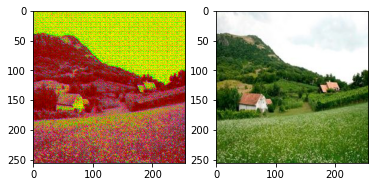

Time for batch  40 / 625 =  0.5599322319030762 , Loss Generator  =  22.433330535888672  , Loss Discriminator =  0.5064738988876343
Time for batch  80 / 625 =  0.5395219326019287 , Loss Generator  =  19.857952117919922  , Loss Discriminator =  0.7164367437362671
Time for batch  120 / 625 =  0.5287737846374512 , Loss Generator  =  15.69554615020752  , Loss Discriminator =  0.6009367108345032
Time for batch  160 / 625 =  0.5354776382446289 , Loss Generator  =  13.67146110534668  , Loss Discriminator =  1.1230969429016113
Time for batch  200 / 625 =  0.5438835620880127 , Loss Generator  =  13.567604064941406  , Loss Discriminator =  0.8070762753486633
Time for batch  240 / 625 =  0.5354504585266113 , Loss Generator  =  14.590319633483887  , Loss Discriminator =  0.4280519187450409
Time for batch  280 / 625 =  0.5325601100921631 , Loss Generator  =  11.677346229553223  , Loss Discriminator =  0.7829650640487671
Generated Image ---------------Ground Truth Image


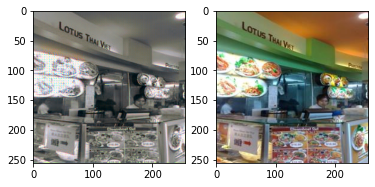

Time for batch  320 / 625 =  0.5374476909637451 , Loss Generator  =  14.998697280883789  , Loss Discriminator =  0.39512473344802856
Time for batch  360 / 625 =  0.5399203300476074 , Loss Generator  =  15.585443496704102  , Loss Discriminator =  0.4942716360092163
Time for batch  400 / 625 =  0.5438194274902344 , Loss Generator  =  11.206576347351074  , Loss Discriminator =  0.7864413261413574
Time for batch  440 / 625 =  0.5327160358428955 , Loss Generator  =  15.781660079956055  , Loss Discriminator =  0.3634885549545288
Time for batch  480 / 625 =  0.5372931957244873 , Loss Generator  =  14.328856468200684  , Loss Discriminator =  0.34322041273117065
Time for batch  520 / 625 =  0.536975622177124 , Loss Generator  =  11.827523231506348  , Loss Discriminator =  0.41072970628738403
Time for batch  560 / 625 =  0.533111572265625 , Loss Generator  =  14.251311302185059  , Loss Discriminator =  0.4156888723373413
Generated Image ---------------Ground Truth Image


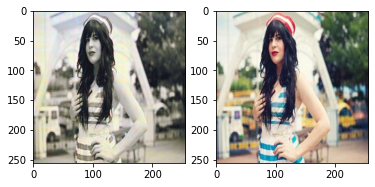

Time for batch  600 / 625 =  0.5376574993133545 , Loss Generator  =  14.73795223236084  , Loss Discriminator =  0.35480478405952454
Saving check point for  1  epoch 

 epoch  1  completed

 
 Generator Loss Plot


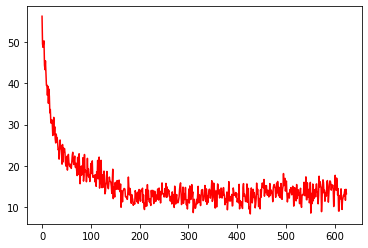



 Discriminator Loss Plot


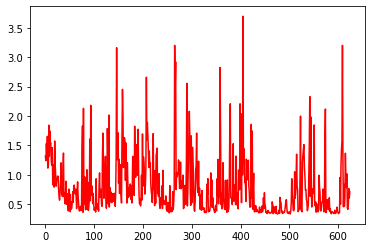

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  3.934828996658325 , Loss Generator  =  8.34609603881836  , Loss Discriminator =  1.1864547729492188
Generated Image ---------------Ground Truth Image


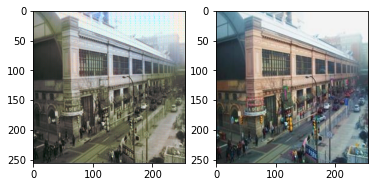

Time for batch  40 / 625 =  0.5430021286010742 , Loss Generator  =  10.870190620422363  , Loss Discriminator =  0.5156999230384827
Time for batch  80 / 625 =  0.5340549945831299 , Loss Generator  =  18.02603530883789  , Loss Discriminator =  0.6877326965332031
Time for batch  120 / 625 =  0.5335814952850342 , Loss Generator  =  15.087831497192383  , Loss Discriminator =  0.3359259068965912
Time for batch  160 / 625 =  0.5337674617767334 , Loss Generator  =  11.524052619934082  , Loss Discriminator =  0.43603891134262085
Time for batch  200 / 625 =  0.5354495048522949 , Loss Generator  =  9.013697624206543  , Loss Discriminator =  1.2455686330795288
Time for batch  240 / 625 =  0.5309493541717529 , Loss Generator  =  8.822723388671875  , Loss Discriminator =  1.2070214748382568
Time for batch  280 / 625 =  0.5328412055969238 , Loss Generator  =  9.80652141571045  , Loss Discriminator =  0.661430835723877
Generated Image ---------------Ground Truth Image


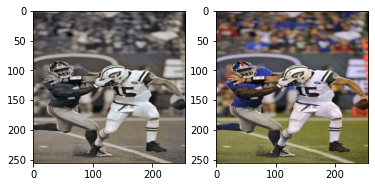

Time for batch  320 / 625 =  0.5336763858795166 , Loss Generator  =  11.971911430358887  , Loss Discriminator =  0.7904984951019287
Time for batch  360 / 625 =  0.5374891757965088 , Loss Generator  =  8.466798782348633  , Loss Discriminator =  1.1105561256408691
Time for batch  400 / 625 =  0.5333802700042725 , Loss Generator  =  12.137262344360352  , Loss Discriminator =  0.47571563720703125
Time for batch  440 / 625 =  0.5332281589508057 , Loss Generator  =  8.408378601074219  , Loss Discriminator =  1.2144920825958252
Time for batch  480 / 625 =  0.5336174964904785 , Loss Generator  =  11.276509284973145  , Loss Discriminator =  0.6041202545166016
Time for batch  520 / 625 =  0.5326335430145264 , Loss Generator  =  9.31543254852295  , Loss Discriminator =  1.8443732261657715
Time for batch  560 / 625 =  0.5353419780731201 , Loss Generator  =  12.25021743774414  , Loss Discriminator =  0.624383807182312
Generated Image ---------------Ground Truth Image


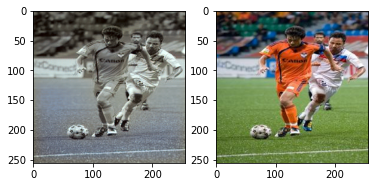

Time for batch  600 / 625 =  0.5339901447296143 , Loss Generator  =  9.567588806152344  , Loss Discriminator =  0.7492750287055969
Saving check point for  2  epoch 

 epoch  2  completed

 
 Generator Loss Plot


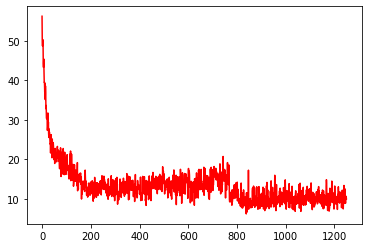



 Discriminator Loss Plot


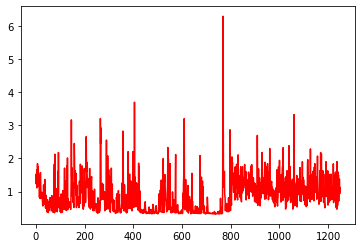

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  4.022814750671387 , Loss Generator  =  11.16694450378418  , Loss Discriminator =  0.617239236831665
Generated Image ---------------Ground Truth Image


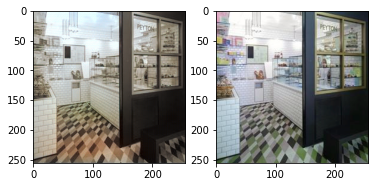

Time for batch  40 / 625 =  0.5342142581939697 , Loss Generator  =  12.125385284423828  , Loss Discriminator =  1.1963481903076172
Time for batch  80 / 625 =  0.5335135459899902 , Loss Generator  =  10.701504707336426  , Loss Discriminator =  0.6046153903007507
Time for batch  120 / 625 =  0.5379741191864014 , Loss Generator  =  8.219606399536133  , Loss Discriminator =  0.8124887347221375
Time for batch  160 / 625 =  0.529226541519165 , Loss Generator  =  8.76059627532959  , Loss Discriminator =  0.5816087126731873
Time for batch  200 / 625 =  0.5337855815887451 , Loss Generator  =  10.220813751220703  , Loss Discriminator =  0.5775735974311829
Time for batch  240 / 625 =  0.5319428443908691 , Loss Generator  =  10.507251739501953  , Loss Discriminator =  0.824852466583252
Time for batch  280 / 625 =  0.5306079387664795 , Loss Generator  =  12.733100891113281  , Loss Discriminator =  0.5954415798187256
Generated Image ---------------Ground Truth Image


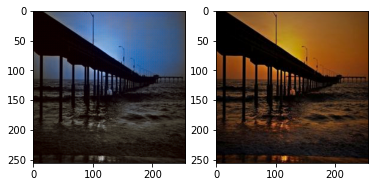

Time for batch  320 / 625 =  0.5337429046630859 , Loss Generator  =  7.511190414428711  , Loss Discriminator =  1.3118010759353638
Time for batch  360 / 625 =  0.5330243110656738 , Loss Generator  =  10.396713256835938  , Loss Discriminator =  0.9411435127258301
Time for batch  400 / 625 =  0.5306441783905029 , Loss Generator  =  10.329402923583984  , Loss Discriminator =  1.3160252571105957
Time for batch  440 / 625 =  0.5322849750518799 , Loss Generator  =  9.913219451904297  , Loss Discriminator =  1.0566990375518799
Time for batch  480 / 625 =  0.5320034027099609 , Loss Generator  =  8.169868469238281  , Loss Discriminator =  1.8469070196151733
Time for batch  520 / 625 =  0.5311827659606934 , Loss Generator  =  10.994661331176758  , Loss Discriminator =  1.006247878074646
Time for batch  560 / 625 =  0.5311264991760254 , Loss Generator  =  11.053855895996094  , Loss Discriminator =  0.5153146982192993
Generated Image ---------------Ground Truth Image


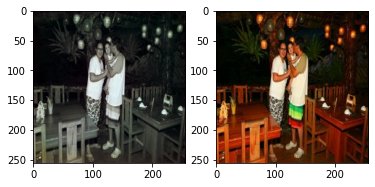

Time for batch  600 / 625 =  0.5307855606079102 , Loss Generator  =  9.017853736877441  , Loss Discriminator =  1.6215286254882812
Saving check point for  3  epoch 

 epoch  3  completed

 
 Generator Loss Plot


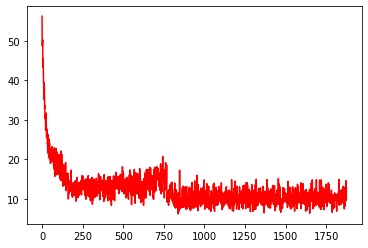



 Discriminator Loss Plot


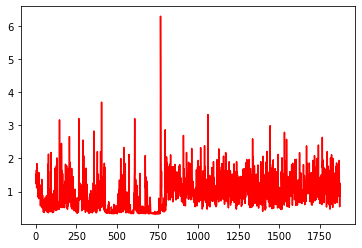

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  3.5918452739715576 , Loss Generator  =  9.77781867980957  , Loss Discriminator =  0.662726879119873
Generated Image ---------------Ground Truth Image


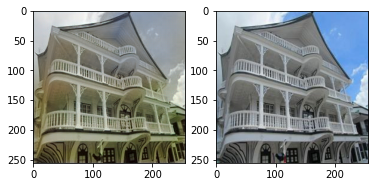

Time for batch  40 / 625 =  0.5311756134033203 , Loss Generator  =  9.275823593139648  , Loss Discriminator =  1.0584907531738281
Time for batch  80 / 625 =  0.5296249389648438 , Loss Generator  =  9.54153823852539  , Loss Discriminator =  1.6851543188095093
Time for batch  120 / 625 =  0.5283055305480957 , Loss Generator  =  12.336594581604004  , Loss Discriminator =  0.728721559047699
Time for batch  160 / 625 =  0.5304720401763916 , Loss Generator  =  11.604673385620117  , Loss Discriminator =  0.7298191785812378
Time for batch  200 / 625 =  0.5279605388641357 , Loss Generator  =  10.151656150817871  , Loss Discriminator =  0.9357929229736328
Time for batch  240 / 625 =  0.53558349609375 , Loss Generator  =  10.38843059539795  , Loss Discriminator =  0.6261451244354248
Time for batch  280 / 625 =  0.5311691761016846 , Loss Generator  =  11.625155448913574  , Loss Discriminator =  1.4977960586547852
Generated Image ---------------Ground Truth Image


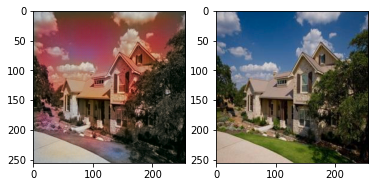

Time for batch  320 / 625 =  0.5298564434051514 , Loss Generator  =  9.97443962097168  , Loss Discriminator =  0.9503577351570129
Time for batch  360 / 625 =  0.5311565399169922 , Loss Generator  =  8.455552101135254  , Loss Discriminator =  0.9737614393234253
Time for batch  400 / 625 =  0.5324182510375977 , Loss Generator  =  8.955992698669434  , Loss Discriminator =  2.235114336013794
Time for batch  440 / 625 =  0.5278749465942383 , Loss Generator  =  8.079581260681152  , Loss Discriminator =  1.377751111984253
Time for batch  480 / 625 =  0.5283288955688477 , Loss Generator  =  10.48929500579834  , Loss Discriminator =  0.8224164247512817
Time for batch  520 / 625 =  0.5353484153747559 , Loss Generator  =  11.939411163330078  , Loss Discriminator =  0.700067400932312
Time for batch  560 / 625 =  0.5276267528533936 , Loss Generator  =  8.907065391540527  , Loss Discriminator =  1.1856689453125
Generated Image ---------------Ground Truth Image


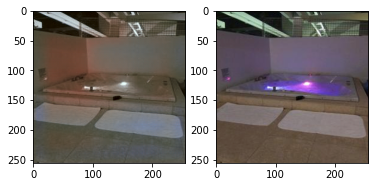

Time for batch  600 / 625 =  0.5380477905273438 , Loss Generator  =  11.252012252807617  , Loss Discriminator =  0.5260058045387268
Saving check point for  4  epoch 

 epoch  4  completed

 
 Generator Loss Plot


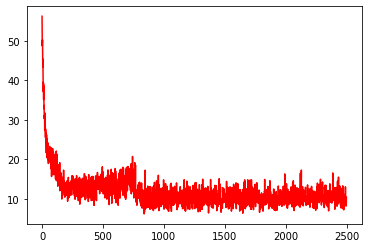



 Discriminator Loss Plot


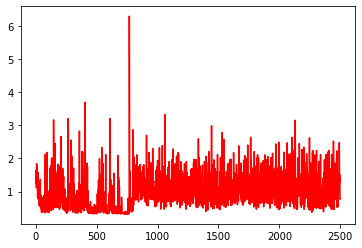

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  4.027052879333496 , Loss Generator  =  8.943708419799805  , Loss Discriminator =  0.7162913084030151
Generated Image ---------------Ground Truth Image


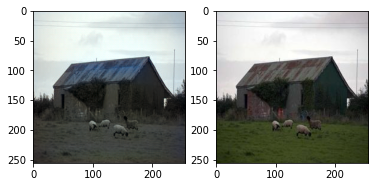

Time for batch  40 / 625 =  0.5342099666595459 , Loss Generator  =  9.50783920288086  , Loss Discriminator =  0.8510646820068359
Time for batch  80 / 625 =  0.5315322875976562 , Loss Generator  =  9.138806343078613  , Loss Discriminator =  2.167829990386963
Time for batch  120 / 625 =  0.5292348861694336 , Loss Generator  =  8.521050453186035  , Loss Discriminator =  1.6106466054916382
Time for batch  160 / 625 =  0.5311930179595947 , Loss Generator  =  10.560796737670898  , Loss Discriminator =  0.6155272722244263
Time for batch  200 / 625 =  0.5309059619903564 , Loss Generator  =  9.104137420654297  , Loss Discriminator =  1.1547846794128418
Time for batch  240 / 625 =  0.5310137271881104 , Loss Generator  =  14.497235298156738  , Loss Discriminator =  0.7298736572265625
Time for batch  280 / 625 =  0.5283596515655518 , Loss Generator  =  11.041711807250977  , Loss Discriminator =  1.0288629531860352
Generated Image ---------------Ground Truth Image


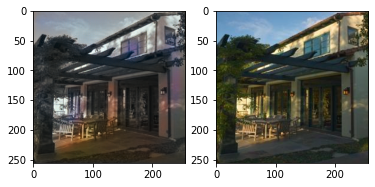

Time for batch  320 / 625 =  0.5324769020080566 , Loss Generator  =  9.380878448486328  , Loss Discriminator =  0.8505250811576843
Time for batch  360 / 625 =  0.5295493602752686 , Loss Generator  =  12.005664825439453  , Loss Discriminator =  0.8684866428375244
Time for batch  400 / 625 =  0.5303122997283936 , Loss Generator  =  11.625836372375488  , Loss Discriminator =  0.7515193223953247
Time for batch  440 / 625 =  0.5291712284088135 , Loss Generator  =  8.602385520935059  , Loss Discriminator =  1.4044790267944336
Time for batch  480 / 625 =  0.5292086601257324 , Loss Generator  =  11.056685447692871  , Loss Discriminator =  0.4508681297302246
Time for batch  520 / 625 =  0.5299534797668457 , Loss Generator  =  9.459704399108887  , Loss Discriminator =  1.5096333026885986
Time for batch  560 / 625 =  0.5287535190582275 , Loss Generator  =  10.014772415161133  , Loss Discriminator =  1.2832717895507812
Generated Image ---------------Ground Truth Image


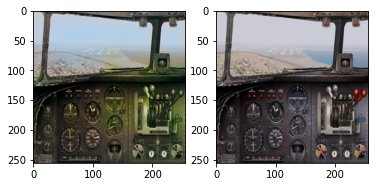

Time for batch  600 / 625 =  0.5283677577972412 , Loss Generator  =  9.68131160736084  , Loss Discriminator =  1.219066858291626
Saving check point for  5  epoch 

 epoch  5  completed

 
 Generator Loss Plot


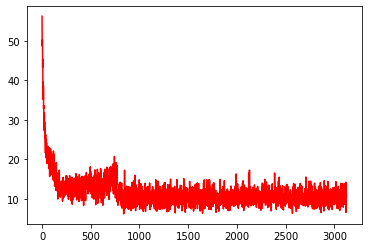



 Discriminator Loss Plot


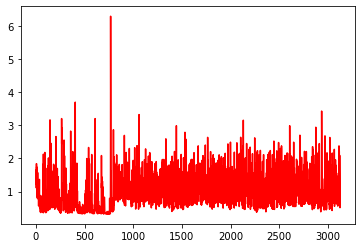

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  3.6931068897247314 , Loss Generator  =  9.77077865600586  , Loss Discriminator =  1.3302894830703735
Generated Image ---------------Ground Truth Image


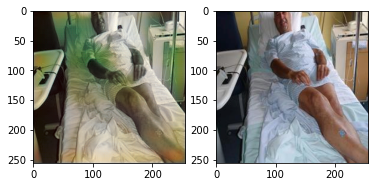

Time for batch  40 / 625 =  0.5328085422515869 , Loss Generator  =  9.663918495178223  , Loss Discriminator =  0.6669808626174927
Time for batch  80 / 625 =  0.534064769744873 , Loss Generator  =  10.795219421386719  , Loss Discriminator =  0.6857612729072571
Time for batch  120 / 625 =  0.5292649269104004 , Loss Generator  =  10.590694427490234  , Loss Discriminator =  1.137812614440918
Time for batch  160 / 625 =  0.5265350341796875 , Loss Generator  =  9.020417213439941  , Loss Discriminator =  0.674045741558075
Time for batch  200 / 625 =  0.52801513671875 , Loss Generator  =  10.482608795166016  , Loss Discriminator =  1.1741814613342285
Time for batch  240 / 625 =  0.5288796424865723 , Loss Generator  =  9.69815731048584  , Loss Discriminator =  1.0643489360809326
Time for batch  280 / 625 =  0.5344367027282715 , Loss Generator  =  12.346325874328613  , Loss Discriminator =  0.5067784190177917
Generated Image ---------------Ground Truth Image


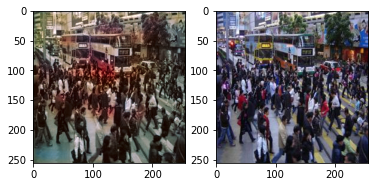

Time for batch  320 / 625 =  0.5355796813964844 , Loss Generator  =  10.755224227905273  , Loss Discriminator =  0.5925830602645874
Time for batch  360 / 625 =  0.5309238433837891 , Loss Generator  =  10.329874992370605  , Loss Discriminator =  1.0999771356582642
Time for batch  400 / 625 =  0.5292587280273438 , Loss Generator  =  10.893495559692383  , Loss Discriminator =  0.4235983192920685
Time for batch  440 / 625 =  0.5284950733184814 , Loss Generator  =  11.357429504394531  , Loss Discriminator =  0.8969007730484009
Time for batch  480 / 625 =  0.5281651020050049 , Loss Generator  =  10.912361145019531  , Loss Discriminator =  0.6756315231323242
Time for batch  520 / 625 =  0.5363140106201172 , Loss Generator  =  10.89993667602539  , Loss Discriminator =  0.7173835039138794
Time for batch  560 / 625 =  0.5315344333648682 , Loss Generator  =  12.438193321228027  , Loss Discriminator =  0.789598286151886
Generated Image ---------------Ground Truth Image


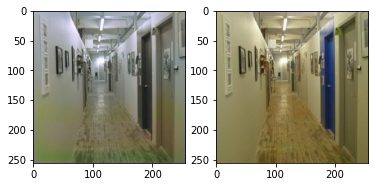

Time for batch  600 / 625 =  0.5324265956878662 , Loss Generator  =  11.230768203735352  , Loss Discriminator =  0.471213161945343
Saving check point for  6  epoch 

 epoch  6  completed

 
 Generator Loss Plot


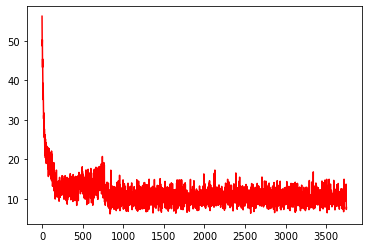



 Discriminator Loss Plot


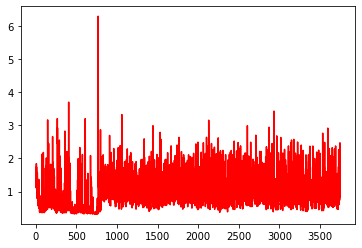

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  3.559978723526001 , Loss Generator  =  10.502630233764648  , Loss Discriminator =  1.1473147869110107
Generated Image ---------------Ground Truth Image


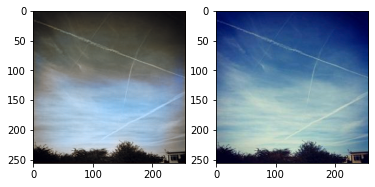

Time for batch  40 / 625 =  0.5368781089782715 , Loss Generator  =  9.838139533996582  , Loss Discriminator =  0.5583567023277283
Time for batch  80 / 625 =  0.5329022407531738 , Loss Generator  =  9.608003616333008  , Loss Discriminator =  0.9030426740646362
Time for batch  120 / 625 =  0.5299973487854004 , Loss Generator  =  12.653352737426758  , Loss Discriminator =  0.6229039430618286
Time for batch  160 / 625 =  0.5305445194244385 , Loss Generator  =  10.804758071899414  , Loss Discriminator =  0.7771795392036438
Time for batch  200 / 625 =  0.5336141586303711 , Loss Generator  =  9.576213836669922  , Loss Discriminator =  1.682907223701477
Time for batch  240 / 625 =  0.5362510681152344 , Loss Generator  =  12.21891975402832  , Loss Discriminator =  0.8635308742523193
Time for batch  280 / 625 =  0.5340917110443115 , Loss Generator  =  11.402959823608398  , Loss Discriminator =  0.883913516998291
Generated Image ---------------Ground Truth Image


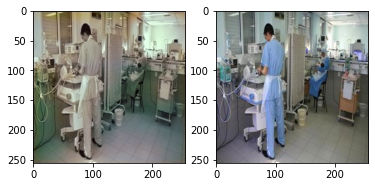

Time for batch  320 / 625 =  0.5321671962738037 , Loss Generator  =  13.539942741394043  , Loss Discriminator =  0.8344479203224182
Time for batch  360 / 625 =  0.5300490856170654 , Loss Generator  =  11.046175003051758  , Loss Discriminator =  0.8072114586830139
Time for batch  400 / 625 =  0.5346250534057617 , Loss Generator  =  8.980667114257812  , Loss Discriminator =  0.9771233201026917
Time for batch  440 / 625 =  0.5311212539672852 , Loss Generator  =  8.3687162399292  , Loss Discriminator =  1.1853749752044678
Time for batch  480 / 625 =  0.546288251876831 , Loss Generator  =  15.17348861694336  , Loss Discriminator =  0.7372980713844299
Time for batch  520 / 625 =  0.5344333648681641 , Loss Generator  =  10.557588577270508  , Loss Discriminator =  3.2428274154663086
Time for batch  560 / 625 =  0.5350024700164795 , Loss Generator  =  8.206631660461426  , Loss Discriminator =  1.4996821880340576
Generated Image ---------------Ground Truth Image


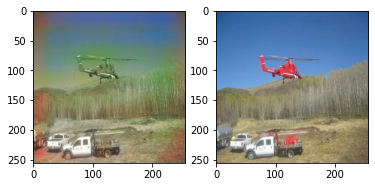

Time for batch  600 / 625 =  0.5348813533782959 , Loss Generator  =  14.046704292297363  , Loss Discriminator =  0.6195334196090698
Saving check point for  7  epoch 

 epoch  7  completed

 
 Generator Loss Plot


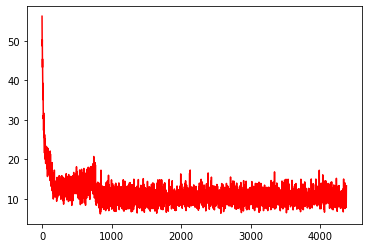



 Discriminator Loss Plot


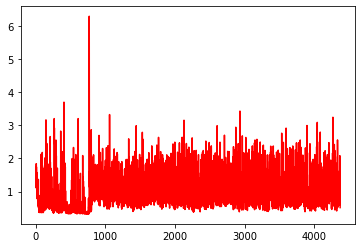

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  3.7933902740478516 , Loss Generator  =  10.826021194458008  , Loss Discriminator =  0.9884315729141235
Generated Image ---------------Ground Truth Image


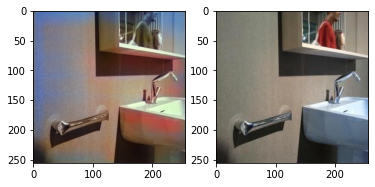

Time for batch  40 / 625 =  0.5326542854309082 , Loss Generator  =  10.049969673156738  , Loss Discriminator =  0.4791121184825897
Time for batch  80 / 625 =  0.5369462966918945 , Loss Generator  =  10.685445785522461  , Loss Discriminator =  0.7983217239379883
Time for batch  120 / 625 =  0.5335941314697266 , Loss Generator  =  13.443633079528809  , Loss Discriminator =  0.6998417377471924
Time for batch  160 / 625 =  0.5303916931152344 , Loss Generator  =  8.074298858642578  , Loss Discriminator =  0.9739595055580139
Time for batch  200 / 625 =  0.5389776229858398 , Loss Generator  =  14.269526481628418  , Loss Discriminator =  0.6570388674736023
Time for batch  240 / 625 =  0.5313780307769775 , Loss Generator  =  7.980842590332031  , Loss Discriminator =  1.2444112300872803
Time for batch  280 / 625 =  0.5333390235900879 , Loss Generator  =  8.520925521850586  , Loss Discriminator =  2.2867813110351562
Generated Image ---------------Ground Truth Image


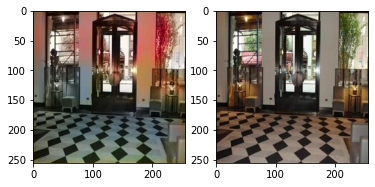

Time for batch  320 / 625 =  0.5331478118896484 , Loss Generator  =  9.827716827392578  , Loss Discriminator =  1.2615087032318115
Time for batch  360 / 625 =  0.5392155647277832 , Loss Generator  =  9.300600051879883  , Loss Discriminator =  1.1294958591461182
Time for batch  400 / 625 =  0.5319564342498779 , Loss Generator  =  9.120373725891113  , Loss Discriminator =  0.7047488689422607
Time for batch  440 / 625 =  0.5336143970489502 , Loss Generator  =  7.907686233520508  , Loss Discriminator =  0.9452857971191406
Time for batch  480 / 625 =  0.5351736545562744 , Loss Generator  =  11.58421516418457  , Loss Discriminator =  2.35636043548584
Time for batch  520 / 625 =  0.5301175117492676 , Loss Generator  =  10.663928985595703  , Loss Discriminator =  0.9865366220474243
Time for batch  560 / 625 =  0.5400180816650391 , Loss Generator  =  10.612678527832031  , Loss Discriminator =  0.8343033790588379
Generated Image ---------------Ground Truth Image


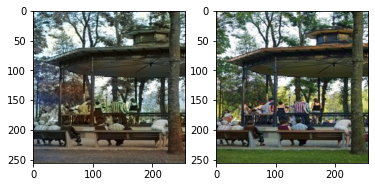

Time for batch  600 / 625 =  0.5287928581237793 , Loss Generator  =  10.680144309997559  , Loss Discriminator =  1.184793472290039
Saving check point for  8  epoch 

 epoch  8  completed

 
 Generator Loss Plot


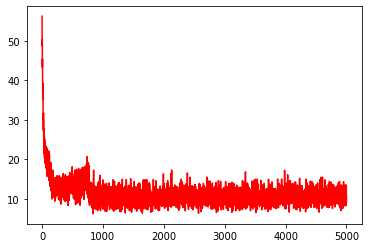



 Discriminator Loss Plot


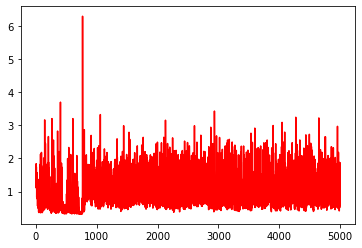

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  4.337018728256226 , Loss Generator  =  8.641409873962402  , Loss Discriminator =  1.6290795803070068
Generated Image ---------------Ground Truth Image


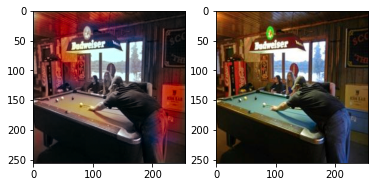

Time for batch  40 / 625 =  0.6135327816009521 , Loss Generator  =  10.618640899658203  , Loss Discriminator =  0.8653799891471863
Time for batch  80 / 625 =  0.5299348831176758 , Loss Generator  =  12.86931324005127  , Loss Discriminator =  0.49164772033691406
Time for batch  120 / 625 =  0.5283095836639404 , Loss Generator  =  10.340275764465332  , Loss Discriminator =  1.3441729545593262
Time for batch  160 / 625 =  0.5296704769134521 , Loss Generator  =  12.052610397338867  , Loss Discriminator =  0.673292875289917
Time for batch  200 / 625 =  0.5251526832580566 , Loss Generator  =  7.65265417098999  , Loss Discriminator =  2.233582019805908
Time for batch  240 / 625 =  0.5299787521362305 , Loss Generator  =  11.266241073608398  , Loss Discriminator =  0.7919470071792603
Time for batch  280 / 625 =  0.5297548770904541 , Loss Generator  =  10.14747428894043  , Loss Discriminator =  0.4267598092556
Generated Image ---------------Ground Truth Image


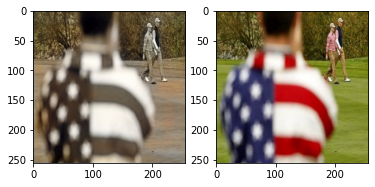

Time for batch  320 / 625 =  0.5322110652923584 , Loss Generator  =  10.21148681640625  , Loss Discriminator =  0.5270951390266418
Time for batch  360 / 625 =  0.5320682525634766 , Loss Generator  =  9.175100326538086  , Loss Discriminator =  1.1864981651306152
Time for batch  400 / 625 =  0.5315384864807129 , Loss Generator  =  8.416319847106934  , Loss Discriminator =  0.5482543110847473
Time for batch  440 / 625 =  0.5280308723449707 , Loss Generator  =  9.049820899963379  , Loss Discriminator =  1.3677783012390137
Time for batch  480 / 625 =  0.5288045406341553 , Loss Generator  =  12.105561256408691  , Loss Discriminator =  0.6639016270637512
Time for batch  520 / 625 =  0.5275099277496338 , Loss Generator  =  14.127086639404297  , Loss Discriminator =  0.6135661602020264
Time for batch  560 / 625 =  0.5280771255493164 , Loss Generator  =  9.395528793334961  , Loss Discriminator =  0.9268850088119507
Generated Image ---------------Ground Truth Image


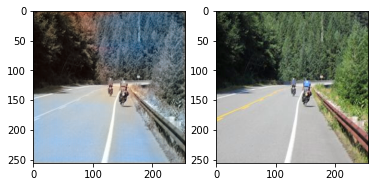

Time for batch  600 / 625 =  0.5274167060852051 , Loss Generator  =  9.494630813598633  , Loss Discriminator =  1.7728214263916016
Saving check point for  9  epoch 

 epoch  9  completed

 
 Generator Loss Plot


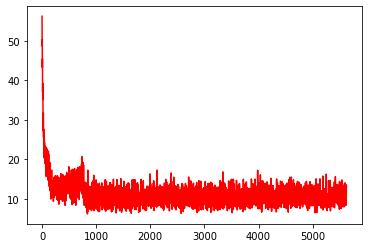



 Discriminator Loss Plot


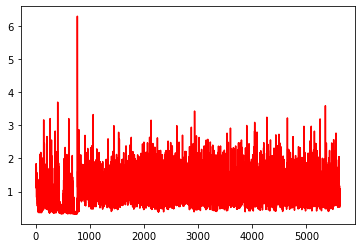

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  3.6402392387390137 , Loss Generator  =  12.955709457397461  , Loss Discriminator =  0.8467627763748169
Generated Image ---------------Ground Truth Image


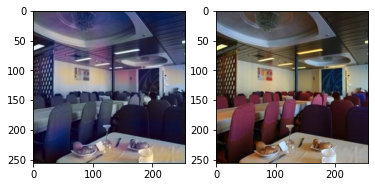

Time for batch  40 / 625 =  0.5270118713378906 , Loss Generator  =  8.61395263671875  , Loss Discriminator =  2.020707130432129
Time for batch  80 / 625 =  0.534599781036377 , Loss Generator  =  10.271931648254395  , Loss Discriminator =  0.913625955581665
Time for batch  120 / 625 =  0.5283730030059814 , Loss Generator  =  7.035589694976807  , Loss Discriminator =  1.528552770614624
Time for batch  160 / 625 =  0.5318882465362549 , Loss Generator  =  13.993687629699707  , Loss Discriminator =  0.45307597517967224
Time for batch  200 / 625 =  0.5318405628204346 , Loss Generator  =  10.209190368652344  , Loss Discriminator =  1.678141474723816
Time for batch  240 / 625 =  0.5321474075317383 , Loss Generator  =  9.831716537475586  , Loss Discriminator =  0.8127033710479736
Time for batch  280 / 625 =  0.5366029739379883 , Loss Generator  =  10.353422164916992  , Loss Discriminator =  0.9082340002059937
Generated Image ---------------Ground Truth Image


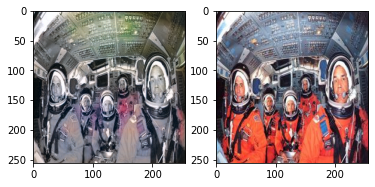

Time for batch  320 / 625 =  0.5324039459228516 , Loss Generator  =  10.25055980682373  , Loss Discriminator =  0.7568991184234619
Time for batch  360 / 625 =  0.5327212810516357 , Loss Generator  =  12.349902153015137  , Loss Discriminator =  0.45778128504753113
Time for batch  400 / 625 =  0.529902458190918 , Loss Generator  =  10.41905689239502  , Loss Discriminator =  1.081701636314392
Time for batch  440 / 625 =  0.5335664749145508 , Loss Generator  =  10.79599666595459  , Loss Discriminator =  0.6939644813537598
Time for batch  480 / 625 =  0.5346469879150391 , Loss Generator  =  10.57037353515625  , Loss Discriminator =  1.152650237083435
Time for batch  520 / 625 =  0.535982608795166 , Loss Generator  =  8.490756034851074  , Loss Discriminator =  1.9911504983901978
Time for batch  560 / 625 =  0.53238844871521 , Loss Generator  =  11.201908111572266  , Loss Discriminator =  1.273864984512329
Generated Image ---------------Ground Truth Image


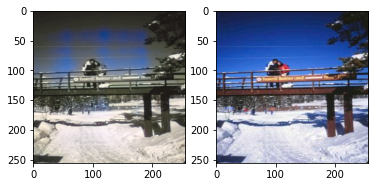

Time for batch  600 / 625 =  0.5301644802093506 , Loss Generator  =  9.24343490600586  , Loss Discriminator =  1.247389554977417
Saving check point for  10  epoch 

 epoch  10  completed

 
 Generator Loss Plot


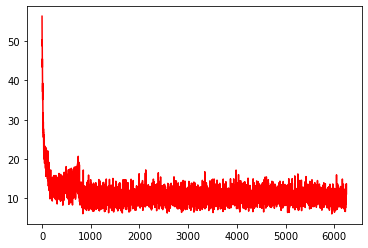



 Discriminator Loss Plot


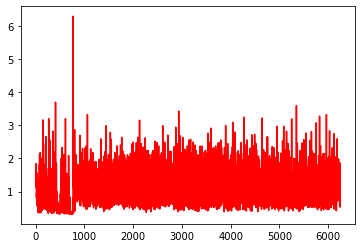

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Time for batch  0 / 625 =  4.181467056274414 , Loss Generator  =  10.817241668701172  , Loss Discriminator =  2.858238458633423
Generated Image ---------------Ground Truth Image


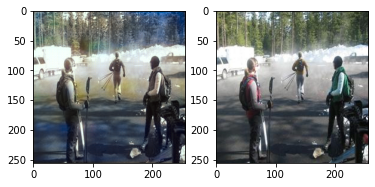

Time for batch  40 / 625 =  0.5323436260223389 , Loss Generator  =  11.9921293258667  , Loss Discriminator =  1.029690146446228
Time for batch  80 / 625 =  0.5627717971801758 , Loss Generator  =  7.390115737915039  , Loss Discriminator =  1.1484510898590088
Time for batch  120 / 625 =  0.5325348377227783 , Loss Generator  =  11.675832748413086  , Loss Discriminator =  1.1470739841461182
Time for batch  160 / 625 =  0.5306417942047119 , Loss Generator  =  10.226499557495117  , Loss Discriminator =  0.5534747838973999
Time for batch  200 / 625 =  0.5378994941711426 , Loss Generator  =  8.19100570678711  , Loss Discriminator =  1.0004937648773193
Time for batch  240 / 625 =  0.5357034206390381 , Loss Generator  =  9.025838851928711  , Loss Discriminator =  1.4699515104293823


In [ ]:
torch.autograd.set_detect_anomaly(True)
from google.colab.patches import cv2_imshow

D_BCE=nn.BCELoss()
G_BCE=nn.BCELoss()
L1=nn.L1Loss()
training = True
time_last = time.time()
while training:
  for i , (gray_imgs , lab_imgs ) in enumerate(train_loader):

    lab_imgs=Variable(lab_imgs.cuda().type(dtype)  )
    gray_imgs=Variable(gray_imgs.cuda().type(dtype)  )

    #update discriminator
    discriminator.zero_grad()
    out = discriminator(torch.cat((gray_imgs , lab_imgs) , 1 )) #Using Ground Truth Image
    out = torch.squeeze(out)
    loss_d_real = D_BCE( out , (0.9*torch.ones(cfg.batch_size ) ).cuda() ) #discriminator Binary Cross Entropy Loss for actual image
    fake_img = generator(gray_imgs).detach()
    out = discriminator(torch.cat((gray_imgs.detach() , fake_img) , 1).detach()) #Using Generated Image
    out =torch.squeeze(out)
    loss_d_fake = D_BCE( out,(torch.zeros(cfg.batch_size)).cuda()) #Discriminator BCE loss for fake generated image
    loss_d = loss_d_real + loss_d_fake
    loss_d.backward()
    loss_D.append(loss_d.item()) 
    optimizer_D.step() 

    #update Generator
    generator.zero_grad()
    fake_img = generator(gray_imgs)
    out = discriminator(torch.cat((gray_imgs , fake_img) , 1) )
    out = torch.squeeze(out)
    loss_g_fake= G_BCE( out ,(torch.ones(cfg.batch_size)).cuda())  #Binary Cross Entropy Loss for generator
    loss_g_l1 = cfg.lambd* L1(fake_img.view(fake_img.size(0),-1),lab_imgs.view(lab_imgs.size(0),-1)) #L1 loss 
    loss_g = loss_g_fake + loss_g_l1
    
    loss_g.backward()
    optimizer_G.step()
    loss_G.append(loss_g.item())
    time_this = time.time()
    batch_time = time_this-time_last
    if i%40==0:
      print("Time for batch " , i , "/", len(train_loader) , "= " , batch_time , ", Loss Generator  = " , loss_g.item() , ' , Loss Discriminator = ' , loss_d.item() )
      if i%7 == 0 :
        with torch.no_grad():
          print('Generated Image ---------------Ground Truth Image')
          f = plt.figure()
          f.add_subplot(1,2, 1)
          i1 = imfakeshow(torch.cat((gray_imgs[0] , fake_img[0]) , 0 ) , True ) 
          i2 = imfakeshow(torch.cat((gray_imgs[0] , lab_imgs[0]) , 0 ) , True )
          plt.imshow(i1)
          f.add_subplot(1,2, 2)
          plt.imshow(i2)
          plt.show(block=True)
          
    time_last = time.time()


  
  save_latest(generator , discriminator , optimizer_G , optimizer_D , step  ) #save weights
  save_loss(loss_G , loss_D)
  print('\n epoch ' , step , ' completed' )
  step+=1
  print('\n \n Generator Loss Plot')
  plt.plot(np.array(loss_G), 'r')
  plt.show()
  print('\n\n Discriminator Loss Plot')
  plt.plot(np.array(loss_D), 'r')
  plt.show()
  if step > cfg.epoch_ul: 
    break
